<a href="https://colab.research.google.com/github/MacherelR/AutonomousRcCar/blob/main/Lane_Navigation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/gdrive')
model_output_dir = '/content/gdrive/My Drive/Colab Notebooks/LaneNavigation'


IMPORTS

In [1]:
# python standard libraries
import os
import random
import fnmatch
import datetime
import pickle

# data processing
import numpy as np
np.set_printoptions(formatter={'float_kind':lambda x: "%.4f" % x})

import pandas as pd
pd.set_option('display.width', 300)
pd.set_option('display.float_format', '{:,.4f}'.format)
pd.set_option('display.max_colwidth', 200)

# tensorflow
import tensorflow as tf
import keras
from keras.models import Sequential  # V2 is tensorflow.keras.xxxx, V1 is keras.xxx
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.optimizers import Adam
from keras.models import load_model

print( f'tf.__version__: {tf.__version__}' )
print( f'keras.__version__: {keras.__version__}' )

# sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# imaging
import cv2
from imgaug import augmenters as img_aug
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image






tf.__version__: 2.4.1
keras.__version__: 2.4.3


Load datas


AutonomousRcCar  sample_data  Trash
image_path: /content/AutonomousRcCar/Datas/images/video01_044_056.png
steering_Angle: 56


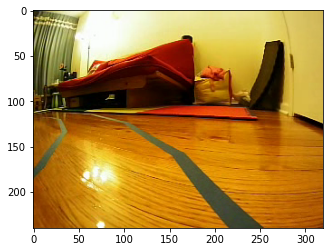

In [7]:
!cd /content
if not os.path.isdir("AutonomousRcCar"):
  !git clone https://github.com/MacherelR/AutonomousRcCar
!ls

dataDirectory = '/content/AutonomousRcCar/Datas/images'

file_list = os.listdir(dataDirectory)
img_path = []
steeringList = []

pattern = "*.png"
for fName in file_list:
  if fnmatch.fnmatch(fName,pattern):
    img_path.append(os.path.join(dataDirectory,fName))
    angle = int(fName[-7:-4]) # last numbers
    steeringList.append(angle)

# Test
idx = 20
plt.imshow(Image.open(img_path[idx]))
print("image_path: %s" % img_path[idx] )
print("steering_Angle: %d" % steeringList[idx] )
df = pd.DataFrame()
df['ImagePath'] = img_path
df['Angle'] = steeringList


Check angle distribution

(array([1.0000, 1.0000, 8.0000, 4.0000, 5.0000, 11.0000, 6.0000, 7.0000,
        26.0000, 2.0000, 10.0000, 21.0000, 18.0000, 23.0000, 15.0000,
        21.0000, 12.0000, 10.0000, 2.0000, 5.0000, 2.0000, 1.0000, 3.0000,
        2.0000, 3.0000]),
 array([44.0000, 46.3600, 48.7200, 51.0800, 53.4400, 55.8000, 58.1600,
        60.5200, 62.8800, 65.2400, 67.6000, 69.9600, 72.3200, 74.6800,
        77.0400, 79.4000, 81.7600, 84.1200, 86.4800, 88.8400, 91.2000,
        93.5600, 95.9200, 98.2800, 100.6400, 103.0000]),
 <a list of 25 Patch objects>)

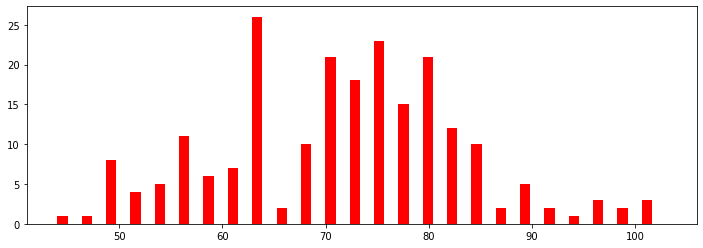

In [8]:
nBins = 25
samplesPerBin = 400
hist , bins = np.histogram(df['Angle'],nBins)

fig,axes = plt.subplots(1,1,figsize=(12,4))
axes.hist(df['Angle'],bins= nBins,width = 1,color='red')

Splitting datas

Training data: 175
Validation data: 44


Text(0.5, 1.0, 'Validation Data')

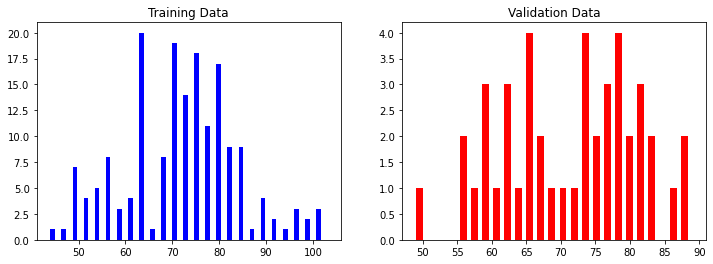

In [10]:
X_train, X_validation, y_train, y_validation = train_test_split(img_path,steeringList, test_size= 0.2)
print("Training data: %d\nValidation data: %d" % (len(X_train), len(X_validation)))

# plot the distributions of train and valid, make sure they are consistent
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(y_train, bins=nBins, width=1, color='blue')
axes[0].set_title('Training Data')
axes[1].hist(y_validation, bins=nBins, width=1, color='red')
axes[1].set_title('Validation Data')

# Nouvelle section